<a href="https://colab.research.google.com/github/N1a2t3a/.Data_Science/blob/main/GoIT_HW_8_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [5]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [6]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [7]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [10]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        # Перший шар, який складається з 128 нейронів
        self.layer1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)
        # Другий шар, який складається з 256 нейронів
        self.layer2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)
        # Вихідний шар
        self.output_layer = DenseLayer(in_features=n_hidden_2, out_features=num_classes)

    def __call__(self, x):
        # Передача даних через перші два шари та вихідний шар з функцією активації softmax
        x = self.layer1(x, activation=True)
        x = self.layer2(x, activation=True)
        output = self.output_layer(x, activation=True)

        return output

# Використання при створенні об'єкта
model = NN()


In [14]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

accuracy_metric = tf.keras.metrics.Accuracy()

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Оновлюємо метрику точності на основі передбачень та правильних міток
    accuracy_metric.update_state(y_true, tf.argmax(y_pred, axis=1))

    # Отримуємо поточне значення точності
    acc = accuracy_metric.result().numpy()

    # Скидаємо метрику для наступної ітерації
    accuracy_metric.reset_states()

    return acc

In [15]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables
    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss

In [16]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    loss = train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        acc = accuracy(pred, batch_y)

        print(f"Крок: {step}, Втрати: {loss}, Точність: {acc}")

        loss_history.append(loss)
        accuracy_history.append(acc)

Крок: 100, Втрати: 586.5255126953125, Точність: 0.15234375
Крок: 200, Втрати: 585.5316772460938, Точність: 0.171875
Крок: 300, Втрати: 584.76025390625, Точність: 0.16015625
Крок: 400, Втрати: 583.7874145507812, Точність: 0.17578125
Крок: 500, Втрати: 583.4835815429688, Точність: 0.1953125
Крок: 600, Втрати: 580.8287353515625, Точність: 0.21875
Крок: 700, Втрати: 580.9013061523438, Точність: 0.26171875
Крок: 800, Втрати: 578.9708251953125, Точність: 0.21875
Крок: 900, Втрати: 576.126220703125, Точність: 0.265625
Крок: 1000, Втрати: 567.5623779296875, Точність: 0.3125
Крок: 1100, Втрати: 563.5972900390625, Точність: 0.296875
Крок: 1200, Втрати: 554.1680908203125, Точність: 0.30078125
Крок: 1300, Втрати: 549.4312133789062, Точність: 0.33203125
Крок: 1400, Втрати: 524.7271728515625, Точність: 0.34375
Крок: 1500, Втрати: 500.729248046875, Точність: 0.37109375
Крок: 1600, Втрати: 498.8199462890625, Точність: 0.328125
Крок: 1700, Втрати: 468.0434265136719, Точність: 0.37890625
Крок: 1800, Втр

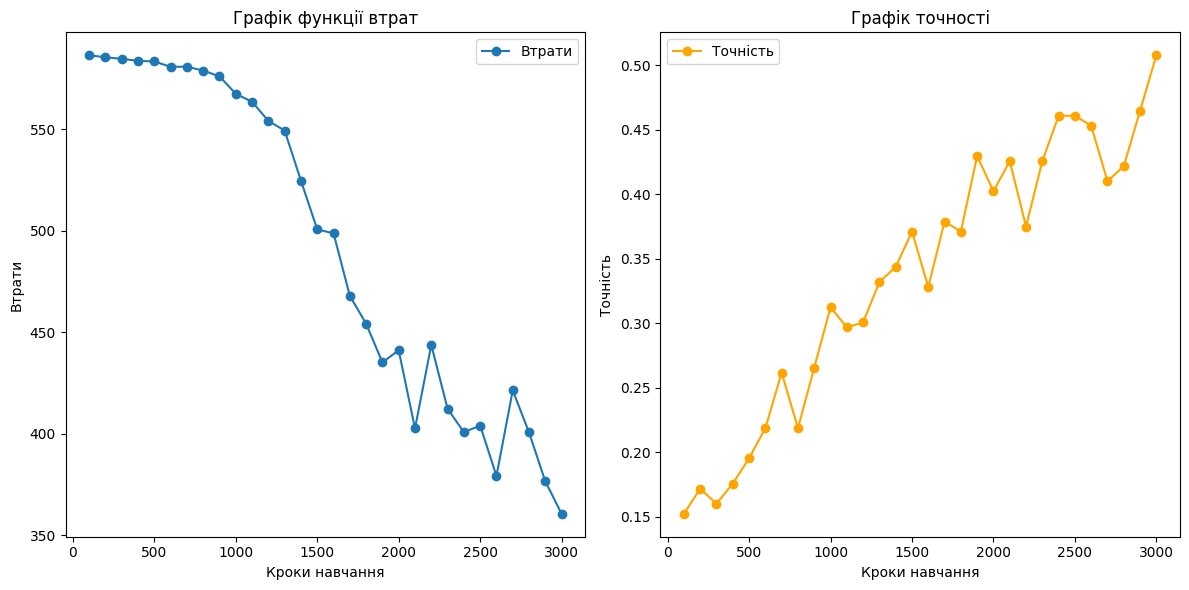

In [17]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведення графіку функції втрат
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(display_step, training_steps + 1, display_step), loss_history, label='Втрати', marker='o')
plt.title('Графік функції втрат')
plt.xlabel('Кроки навчання')
plt.ylabel('Втрати')
plt.legend()

# Виведення графіку точності
plt.subplot(1, 2, 2)
plt.plot(range(display_step, training_steps + 1, display_step), accuracy_history, label='Точність', marker='o', color='orange')
plt.title('Графік точності')
plt.xlabel('Кроки навчання')
plt.ylabel('Точність')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
# Обчисліть точність навченої нейромережі
test_predictions = neural_net(x_test)
test_accuracy = accuracy(test_predictions, y_test)

print(f'Точність на тестових даних: {test_accuracy}')

# Тестування моделі на тестових даних
num_test_samples = 5
random_indices = random.sample(range(len(x_test)), num_test_samples)

for i in random_indices:
    actual_label = int(y_test[i])
    predicted_label = int(tf.argmax(test_predictions[i]))

    print(f"Еталонна мітка: {actual_label}, Передбачення: {predicted_label}")

Точність на тестових даних: 0.46399998664855957
Еталонна мітка: 2, Передбачення: 2
Еталонна мітка: 9, Передбачення: 4
Еталонна мітка: 8, Передбачення: 7
Еталонна мітка: 8, Передбачення: 4
Еталонна мітка: 4, Передбачення: 4


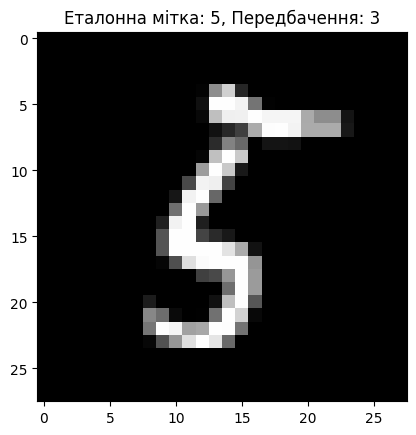

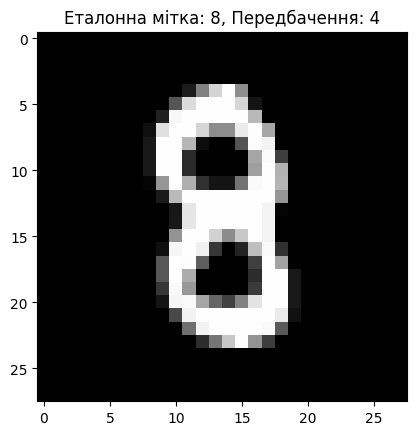

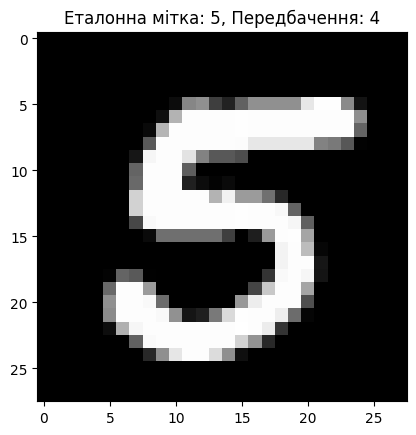

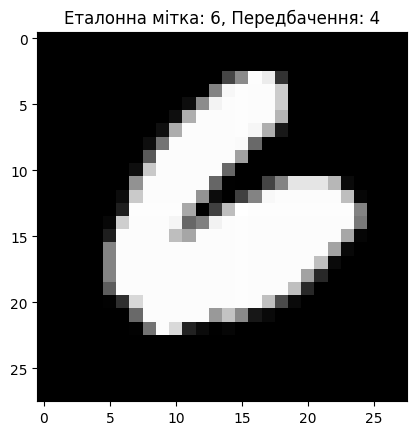

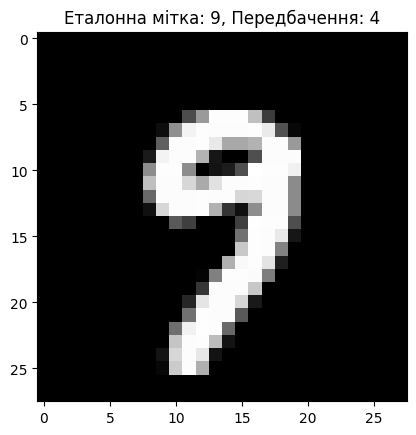

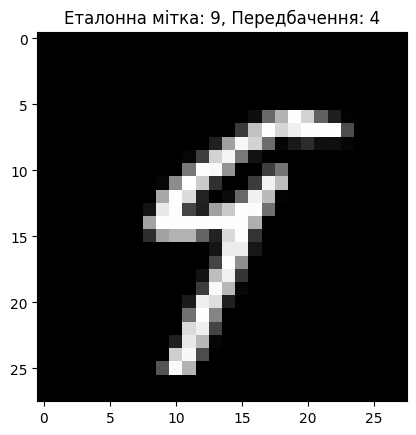

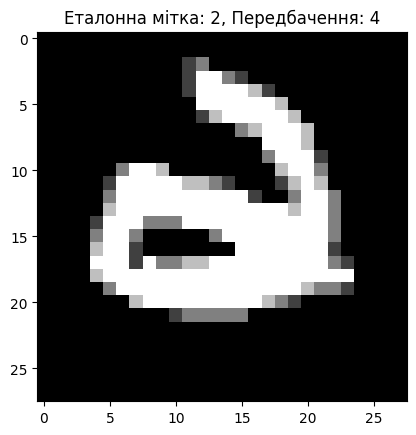

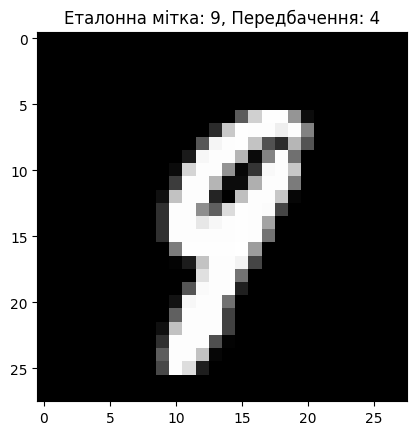

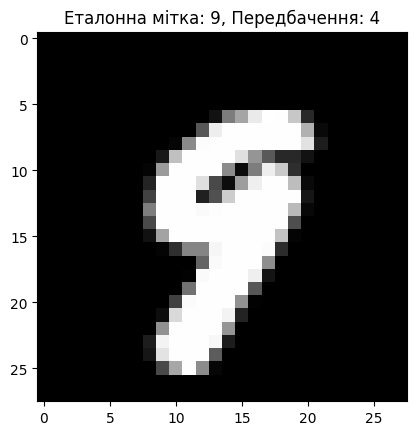

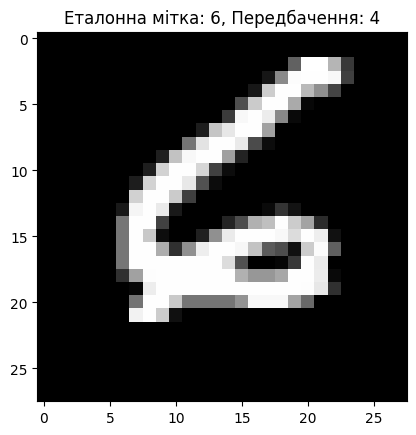

In [19]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

num_test_samples = 10
random_indices = random.sample(range(len(x_test)), num_test_samples)

for i in random_indices:
    predicted_label = int(tf.argmax(test_predictions[i]))

    plt.imshow(x_test[i].reshape((28, 28)), cmap='gray')
    plt.title(f"Еталонна мітка: {y_test[i]}, Передбачення: {predicted_label}")
    plt.show()





Висновок:

Помилки у класифікації: нейронна мережа часто робить помилки у класифікації.

Частота помилок: помилки виникають часто
